<div style="display: flex; background-color:rgb(214, 234, 248 );" >
<h1 style="text-align: center;margin: auto; padding: 40px; "> Segmentez des clients d'un site e-commerce
    Projet 5 Notebook Maintenance</h1>
    <p >  Zeynep Erdem 
      
</p>
      
  
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn import decomposition
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Récupération de nos données :
df = pd.read_csv("rfm_plus_geo.csv")
df.head(2)

,customer_unique_id,Recency,Frequency,MonetaryValue,review_mean,deliver_duration_mean,last_order_purchase_timestamp,customer_lat,customer_lng
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,5.0,6.0,2018-05-10 10:56:27,-23.335331,-46.828647
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,4.0,3.0,2018-05-07 11:11:27,-23.567395,-46.792957


In [3]:
# On convert le tytpe de la colonne date
df["last_order_purchase_timestamp"] = pd.to_datetime(
    df["last_order_purchase_timestamp"]
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96095 entries, 0 to 96094
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_unique_id             96095 non-null  object        
 1   Recency                        96095 non-null  int64         
 2   Frequency                      96095 non-null  int64         
 3   MonetaryValue                  96095 non-null  float64       
 4   review_mean                    96095 non-null  float64       
 5   deliver_duration_mean          96095 non-null  float64       
 6   last_order_purchase_timestamp  96095 non-null  datetime64[ns]
 7   customer_lat                   95827 non-null  float64       
 8   customer_lng                   95827 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 6.6+ MB


In [4]:
first_order = df["last_order_purchase_timestamp"].min()
last_order = df["last_order_purchase_timestamp"].max()

In [5]:
# La date de premier commande
first_order

Timestamp('2016-09-04 21:15:19')

In [6]:
# La date de dernier commande
last_order

Timestamp('2018-10-17 17:30:18')

On va choisir les données de 2017-06-04 à 2018-03-04 pendant 9 mois pour entrainer notre modèle zéro Kmeans de 6 clusters. On standardise nos données. Après on définit les données de 20 jours intervalles jusqu'à la date de dernier commande. On fait les prédictions pour les deux modèles et on va comparer les résultats avec ARI score. 

Le terme "ARI score" est souvent utilisé pour faire référence à l'Adjusted Rand Index (indice de Rand ajusté en français). L'ARI est souvent utilisé pour évaluer la qualité des résultats de clustering, en comparant les résultats obtenus par un algorithme avec une partition de référence (généralement une vérité de terrain ou des étiquettes connues). Cela permet de mesurer à quel point les clusters ou les groupes identifiés par l'algorithme correspondent aux groupes réels.
Il fournit une valeur entre -1 et 1, où -1 indique une absence totale de similarité, 0 indique une similarité aléatoire et 1 indique une similarité parfaite.
Un score ARI élevé indique que les deux partitions sont en accord étroit, tandis qu'un score proche de zéro indique une similarité aléatoire. Un score négatif signifie que les deux partitions sont en désaccord.

In [7]:
features = [
    "Recency",
    "Frequency",
    "MonetaryValue",
    "review_mean",
    "deliver_duration_mean",
]
# features = ['Recency', 'Frequency', 'MonetaryValue', 'review_mean']
# features = ['Recency', 'Frequency', 'MonetaryValue']

# Specify the desired dates for the analysis
first_date = "2017-06-04"
second_date = "2018-03-04"
last_date = "2018-10-17"
n_clusters = 6
# Filter the dataset based on the specified dates
df_selected = df[
    (df["last_order_purchase_timestamp"] >= first_date)
    & (df["last_order_purchase_timestamp"] <= second_date)
]

# On effectue une segmentation sur l'ensemble de données sélectionné.
X = df_selected[features]
X_scaled = StandardScaler().fit_transform(X)
kmeans_first = KMeans(n_clusters=n_clusters, init="k-means++", random_state=3)
kmeans_first.fit(X_scaled)

# On Crée une liste pour stocker les valeurs ARI score.
ari_score = []

# Itérer sur des dates spécifiques.
date_range = pd.date_range(start=second_date, end=last_date, freq="20D")
for date in date_range:
    # Filtrer l'ensemble de données en fonction de la date actuelle.
    df_temp = df[
        (df["last_order_purchase_timestamp"] <= date)
        & (df["last_order_purchase_timestamp"] >= first_date)
    ]
    # On fait le standardisation
    X_temp = df_temp[features]
    X_scaled_temp = StandardScaler().fit_transform(X_temp)
    # On effectue le clustering :
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=3)
    kmeans.fit(X_scaled_temp)
    # On calcule une prédiction sur les données :
    labels = kmeans.predict(X_scaled_temp)
    labels_true = kmeans_first.predict(X_scaled_temp)
    # On calcule l'indice ARI :
    ari = adjusted_rand_score(labels_true, labels)
    ari_score.append([date, ari])
ari_score = pd.DataFrame(ari_score, columns=["date", "ARI"])
# Calculer la date minimum
min_date = ari_score["date"].min()

# Convertir la colonne 'date' en type datetime.
ari_score["date"] = pd.to_datetime(ari_score["date"])

# Convertir la colonne 'date' en nombre de jours.
ari_score_days = ari_score.copy()
ari_score_days["date"] = (ari_score_days["date"] - min_date).dt.days
ari_score_days

,date,ARI
0,0,1.000000
1,20,0.962759
2,40,0.942871
3,60,0.934010
4,80,0.868016
5,100,0.884526
6,120,0.903044
7,140,0.879170
8,160,0.817166
9,180,0.782489


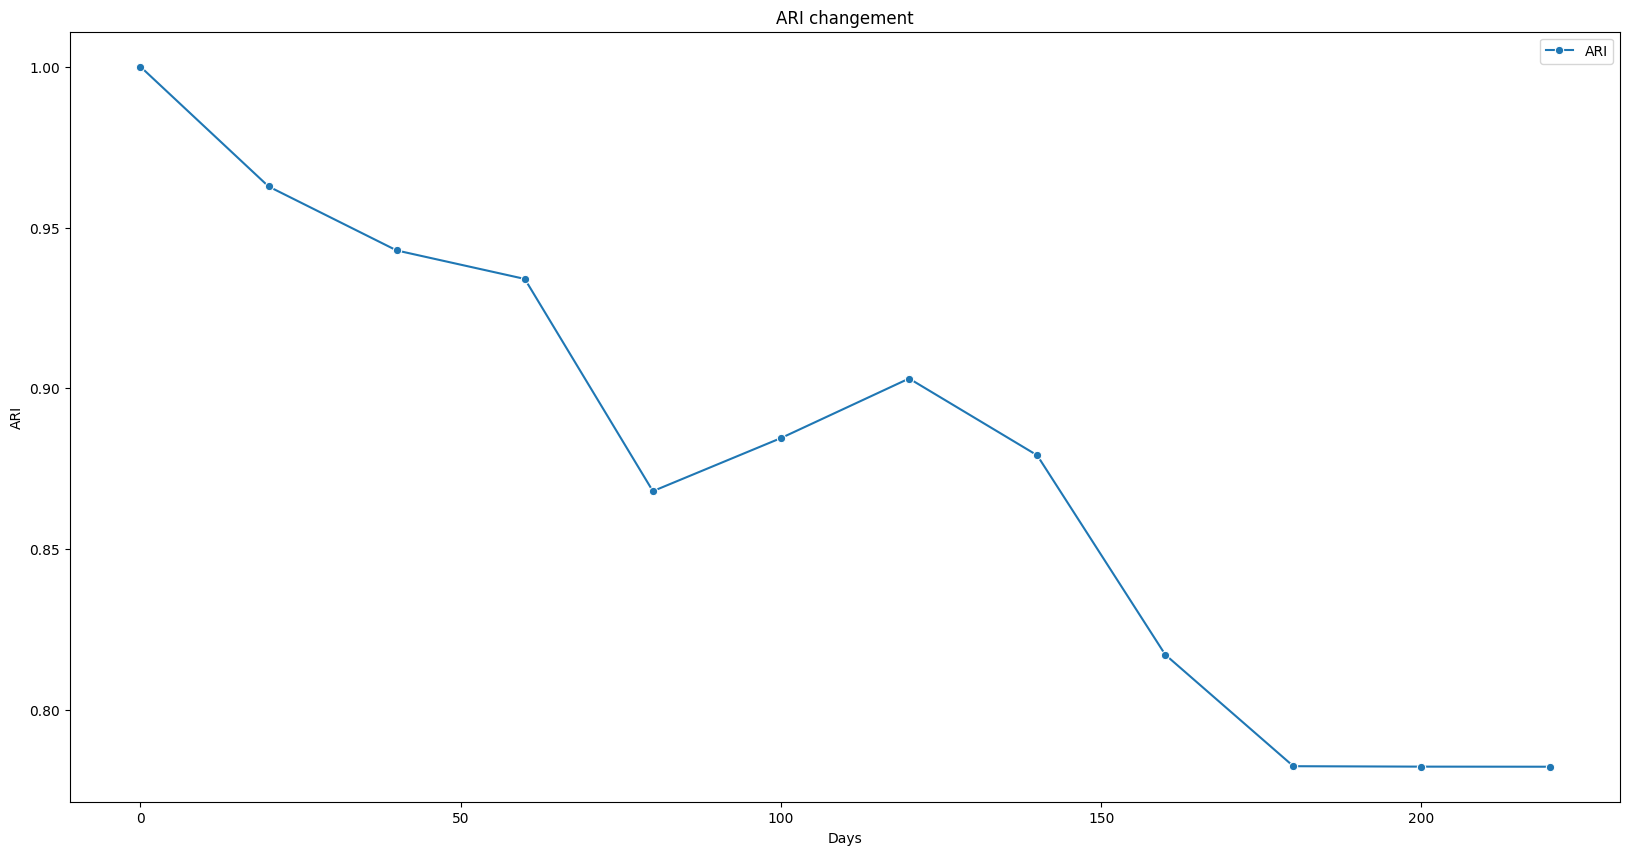

In [8]:
# On affiche le graphique :
plt.figure(figsize=(20, 10))
sns.lineplot(x="date", y="ARI", data=ari_score_days, label="ARI", marker="o")
plt.xlabel("Days")
plt.ylabel("ARI")
plt.title("ARI changement")
plt.show()

### D'après les simulations on obtient les résultats moins de 0.80 à partir de 160 jours. Alors on recommande d'une maintenance d'environ 6 mois.